# Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/usr/bin/python


# Install dependencies:

In [ ]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [8]:
data_path = '../../../videoinfo_tUR0LrSadkg_2020_11_26-10_48_15_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [6]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./output/ 


# Load Data
Load you data as a pandas dataframe

In [9]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [10]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [11]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

/usr/local/lib/python3.8/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 2292/2292 [00:00<00:00, 5949.09it/s]

Removed HTML Tags.
Removed Links.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [12]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-10-28 17:16:11,AraAra1234,The more I hear the &quot;97% of scientists...&quot; truism and the more I hear &quot;stop thinking and accept MY truth&quot;.,0,"The more I hear the ""97% of scientists..."" truism and the more I hear ""stop\nthinking and accept MY truth"".\n\n"
1,2020-10-03 21:38:38,Kuroi Ryū,"If you want to know more about Bjørn Lomborg, see this: <a href=""https://www.dr.dk/drtv/se/taet-paa-sandheden_-hockeystavens-hemmelighed_171271"">https://www.dr.dk/drtv/se/taet-paa-sandheden_-hockeystavens-hemmelighed_171271</a>",0,"If you want to know more about Bjørn Lomborg, see this:\n\n\n"
2,2020-08-23 02:42:21,SmpKnght,"facts are lies or cherrypicked check for yourself, don&#39;t believe propoganda and point without checking first.",0,"facts are lies or cherrypicked check for yourself, don't believe propoganda\nand point without checking first.\n\n"
3,2020-08-16 22:23:38,L337M4573RK,"Anyone ever notice that AOC has never once released her OWN Climate Change calculations to the public? We would certainly love to see how she &quot;calculated&quot; exactly how many years we have left to submit to HER plans, ideas, and beliefs before Climate Change &quot;kills us all&quot;!",0,"Anyone ever notice that AOC has never once released her OWN Climate Change\ncalculations to the public? We would certainly love to see how she\n""calculated"" exactly how many years we have left to submit to HER plans,\nideas, and beliefs before Climate Change ""kills us all""!\n\n"
4,2020-07-03 13:48:27,Akiva Ziskind,"From the speakers Wikipedia page: &quot;After the publication of The Skeptical Environmentalist, Lomborg was formally accused of scientific dishonesty by a group of environmental scientists, who brought a total of three complaints against him to the Danish Committees on Scientific Dishonesty (DCSD), a body under Denmark&#39;s Ministry of Science, Technology and Innovation (MSTI). Lomborg was asked whether he regarded the book as a &quot;debate&quot; publication, and thereby not under the purview of the DCSD, or as a scientific work; he chose the latter, clearing the way for the inquiry that followed.[37] The charges claimed that The Skeptical Environmentalist contained deliberately misleading data and flawed conclusions. Due to the similarity of the complaints, the DCSD decided to proceed on the three cases under one investigation.&quot;",0,"From the speakers Wikipedia page: ""After the publication of The Skeptical\nEnvironmentalist, Lomborg was formally accused of scientific dishonesty by a\ngroup of environmental scientists, who brought a total of three complaints\nagainst him to the Danish Committees on Scientific Dishonesty (DCSD), a body\nunder Denmark's Ministry of Science, Technology and Innovation (MSTI). Lomborg\nwas asked whether he regarded the book as a ""debate"" publication, and thereby\nnot under the purview of the DCSD, or as a scientific work; he chose the\nlatter, clearing the way for the inquiry that followed.[37] The charges\nclaimed that The Skeptical Environmentalist contained deliberately misleading\ndata and flawed conclusions. Due to the similarity of the complaints, the DCSD\ndecided to proceed on the three cases under one investigation.""\n\n"


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [13]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [14]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 8 9 10 11 The embeddings vector is of fixed length 512


TensorShape([2292, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000004   0.12323913  0.2378596  ...  0.11989266  0.05500869
   0.02176671]
 [ 0.12323913  1.0000002   0.12112156 ... -0.00262079 -0.05647999
  -0.00682868]
 [ 0.2378596   0.12112156  1.         ...  0.05590089  0.00904023
   0.00141725]
 ...
 [ 0.11989266 -0.00262079  0.05590089 ...  1.0000001   0.07842678
   0.06782357]
 [ 0.05500869 -0.05647999  0.00904023 ...  0.07842678  0.9999999
   0.2949561 ]
 [ 0.02176671 -0.00682868  0.00141725 ...  0.06782357  0.2949561
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

/usr/local/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


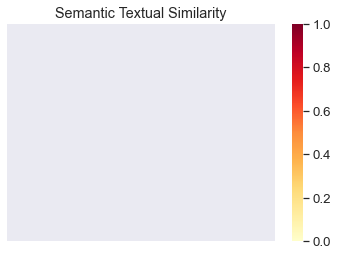

In [16]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [21]:
comment_index = 1537
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

Everyone knows that the wooly mammoths and saber tooth tigers went extinct
because they drove SUVs and ate cheeseburgers




Print similar comments.

In [22]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 10)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: Everyone knows that the wooly mammoths and saber tooth tigers went extinct
because they drove SUVs and ate cheeseburgers


Top similar comment 2: Mammoths went extinct because the earths climate stabilized after the ice age
and warmed to a steady climate. Also over hunting killed them too.
Sabertooth’s died off from starvation(they eat big and a lot)


Top similar comment 3: Meanwhile, the Wooly Rhinos went extinct because they were asking too many
questions.


Top similar comment 4: And polar bears ate all gooslings XD


Top similar comment 5: Guys, when a single volcanic eruption can throw more CO2 up into the
atmosphere than humans do in a year, I don’t think we’re the problem.  
  
  
  
  
Creatures like dinosaurs and wooly mammoths obviously just went extinct
because they were driving too many cars.


Top similar comment 6: Steve E No, extinction was due to woolly mammoth farts. The worst since T Rex
destroyed the dinosaurs with its ripsnorters.


Top simil